# Решение задач классификации и регрессии на данных CASdatasets: Insurance datasets

Для задачи регрессии финальной и легко инитерпретируемой метрикой метрикой может быть r2_score, так как будучи ограниченной в пределах [-1;1] оценивает долю дисперсии, объесняемой ответами.

Для классификации roc-auc отлично подходит, также можно использовать f1_score, который тоже представляет из себя функцию от precision и recall

Для кластеризации использовались метрики calinski_harabasz_score и Silhouette Coefficient

# 1. Задание

# 1.1 Классификация и регрессия

# Данные

Источник данных: http://cas.uqam.ca/. Авторы: Christophe Dutang, Arthur Charpentier. Лицензия: GPL-3

In [ ]:
pip freeze > requirements.txt

**Задача:**

Для заданного набора данных (*task1_train_v5.csv*) решить задачи классификации (целевая переменная *target_classification*, метрика ROC-AUC) и регрессии (целевая переменная *target_regression*, метрика RMSE)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!wget https://github.com/nort358/file/blob/main/task1_train_v5.csv
!wget https://github.com/nort358/file/blob/main/task1_test_v5.csv
!wget https://github.com/nort358/file/blob/main/task2_v5.csv

--2021-06-07 12:09:20--  https://github.com/nort358/file/blob/main/task1_train_v5.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘task1_train_v5.csv’

task1_train_v5.csv      [ <=>                ] 107.82K  --.-KB/s    in 0.04s   

2021-06-07 12:09:20 (2.84 MB/s) - ‘task1_train_v5.csv’ saved [110403]

--2021-06-07 12:09:20--  https://github.com/nort358/file/blob/main/task1_test_v5.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘task1_test_v5.csv’

task1_test_v5.csv       [ <=>                ] 107.80K  --.-KB/s    in 0.04s   

2021-06-07 12:09:20 (2.77 MB/s) - ‘task1_test_v5.csv’ saved [110386]

--2021-06-07 12:09:20--  https://github.com/nort358/file/blob/m

In [ ]:
train = pd.read_csv('/content/task1_train_v5.csv', sep=';')
test = pd.read_csv('/content/task1_test_v5.csv', sep=';')

In [ ]:
train.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,target_regression,target_classification
0,1124750,0.74,C,5.0,10.0,50.0,50.0,B2,Regular,182.0,R82,0.0,0
1,516531,0.78,C,6.0,5.0,40.0,50.0,NaN,Diesel,262.0,R93,0.0,0
2,922566,1.00,E,4.0,12.0,33.0,50.0,B3,Diesel,3103.0,R82,0.0,0
3,335537,NaN,D,4.0,16.0,40.0,100.0,B2,Regular,1313.0,R24,0.0,0
4,1355191,0.34,B,7.0,7.0,42.0,156.0,B5,Regular,57.0,R24,0.0,0


In [ ]:
numeric = train.loc[:,train.dtypes == float].columns[:-1]
categorical = train.loc[:,train.dtypes == object].columns

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339006 entries, 0 to 339005
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   IDpol                  339006 non-null  int64  
 1   Exposure               305106 non-null  float64
 2   Area                   305106 non-null  object 
 3   VehPower               305106 non-null  float64
 4   VehAge                 305106 non-null  float64
 5   DrivAge                305106 non-null  float64
 6   BonusMalus             305106 non-null  float64
 7   VehBrand               305106 non-null  object 
 8   VehGas                 305106 non-null  object 
 9   Density                339006 non-null  float64
 10  Region                 339006 non-null  object 
 11  target_regression      339006 non-null  float64
 12  target_classification  339006 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 33.6+ MB


Так как в данных есть пропуски, то стоит обработать их. В вещественных признаках заменим на медиану, так как она больше устойчива к выбросам, а категориальные на наиболее представленный класс в признаке

In [ ]:
from collections import Counter
def imputer(data, numeric_columns, categorical_columns):
  data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())
  most_common = np.array(list(map(lambda x: Counter(x).most_common(1), data[categorical_columns].values.T))).T[0][0]
  most_common = pd.Series(most_common,index=data[categorical_columns].columns)
  data[categorical_columns] = data[categorical_columns].fillna(most_common)
  return data

In [ ]:
train = imputer(train,numeric,categorical)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339006 entries, 0 to 339005
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   IDpol                  339006 non-null  int64  
 1   Exposure               339006 non-null  float64
 2   Area                   339006 non-null  object 
 3   VehPower               339006 non-null  float64
 4   VehAge                 339006 non-null  float64
 5   DrivAge                339006 non-null  float64
 6   BonusMalus             339006 non-null  float64
 7   VehBrand               339006 non-null  object 
 8   VehGas                 339006 non-null  object 
 9   Density                339006 non-null  float64
 10  Region                 339006 non-null  object 
 11  target_regression      339006 non-null  float64
 12  target_classification  339006 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 33.6+ MB


Построим ящик с усами, чтобы посмотреть, есть ли в данных выбросы. Заменим их на медианыные значения

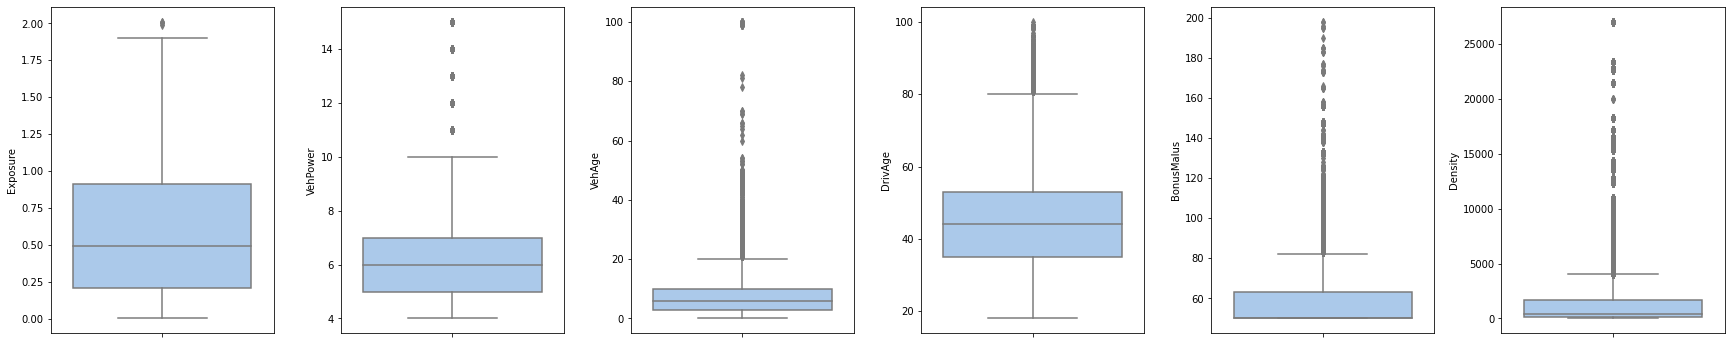

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,6, figsize=(30,6))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i,column in enumerate(train[numeric].columns):
  sns.boxplot(y = train[column], orient='v',ax=ax[i],palette="pastel", data = train)

In [ ]:
train.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,target_regression,target_classification
count,3.390060e+05,339006.000000,339006.000000,339006.000000,339006.000000,339006.000000,339006.000000,3.390060e+05,339006.000000
mean,1.019124e+06,0.524352,6.409069,6.948567,45.333357,58.799709,1787.988977,8.090232e+01,0.050235
std,5.883838e+05,0.345643,1.947610,5.389452,13.419513,15.150538,3940.876176,3.011104e+03,0.218430
min,0.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
25%,5.098405e+05,0.210000,5.000000,3.000000,35.000000,50.000000,92.000000,0.000000e+00,0.000000
50%,1.019928e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
75%,1.528736e+06,0.910000,7.000000,10.000000,53.000000,63.000000,1662.000000,0.000000e+00,0.000000
max,2.034037e+06,2.010000,15.000000,100.000000,100.000000,198.000000,27000.000000,1.404186e+06,1.000000


In [ ]:
def outliers(dataset):
  data = dataset.copy(deep = True)
  description = data.describe()
  max = description.iloc[-2,:]+2*description.iloc[2,:]
  min = description.iloc[3,:]-2*description.iloc[2,:]
  median = train[numeric].median()
  for i,column in enumerate(data):
    data[column][data[column]>max[i]] = median[i]
    data[column][data[column]<min[i]] = median[i]
  return data

In [ ]:
train[numeric] = outliers(train[numeric])

После замены выбросов можно видеть, что в некоторых признаков, где изначально был большой разброс данных с новым пересчетом медианы выбросы остались. Построим ящик с усами с повторным удалением выбросов.

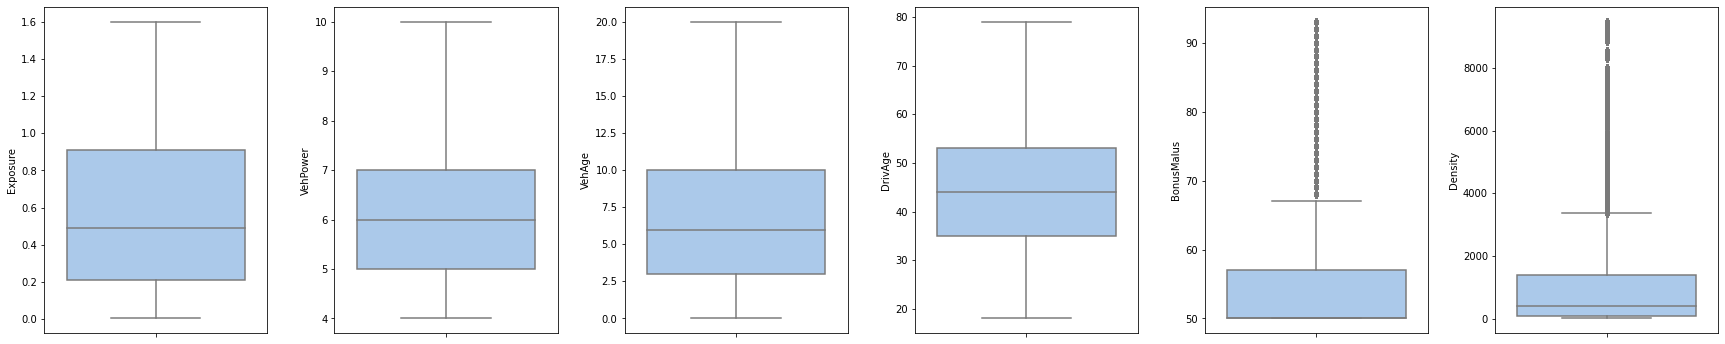

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(30,6))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i,column in enumerate(train[numeric].columns):
  sns.boxplot(y = train[column], orient='v',ax=ax[i],palette="pastel", data = train)

Так как после вторичногог удаления выбросов они остались при новом пересчете квартилей, я решила остановиться на первом варианте и не смещать распределение данных слишком сильно. 

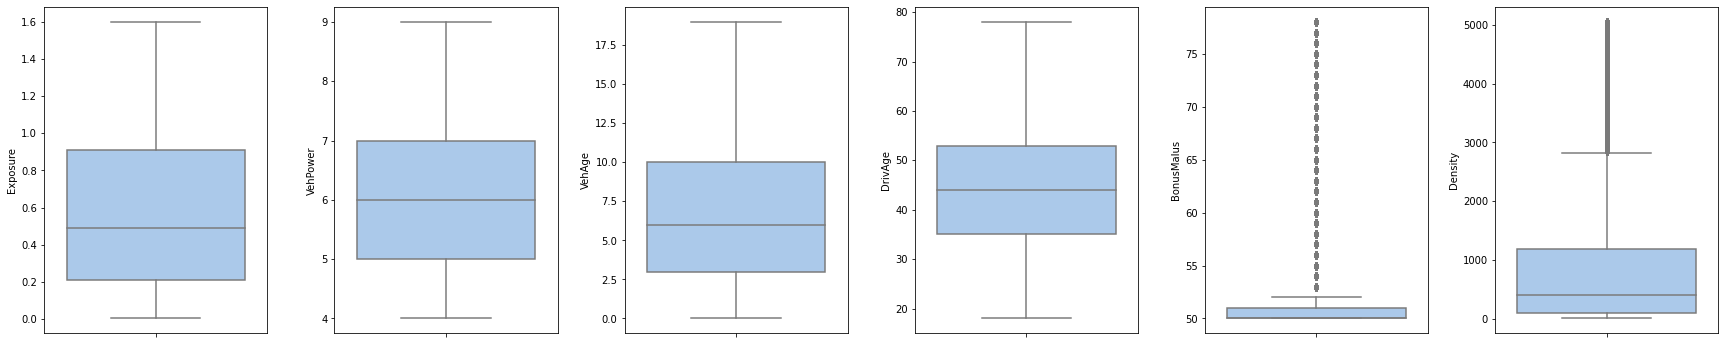

In [ ]:
subtrain = train.copy(deep = True)
# out = Outliers()
subtrain[numeric]= outliers(subtrain[numeric])
fig, ax = plt.subplots(1,6, figsize=(30,6))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i,column in enumerate(subtrain[numeric].columns):
  sns.boxplot(y = subtrain[column], orient='v',ax=ax[i],palette="pastel", data = subtrain)

Так как IDpol - уникальный идентификатор, то его можно удалить

In [ ]:
len(train.iloc[:,0].unique()) == len(train.iloc[:,0])

True

In [ ]:
train = train.drop(train.columns[0],axis = 1)

In [ ]:
y_classification = train['target_classification']
y_regression = train ['target_regression']
X = train.drop(columns= ['target_regression',	'target_classification'])

# EDA 
Посмотрим на распределение тренировочных и тестовых данных, чтобы можно было быть уверенным, что мы можем равнозначно учитывать признаки при построении модели, что применение модели на тестовых данных будет предсказуемым.

 Данные на тренировочной выборке немного смещенно, так как они очищены от выбросов. Можно быть почти уверенным, что предсказание на тесте будет близким к предсказанию на валидационной выборке

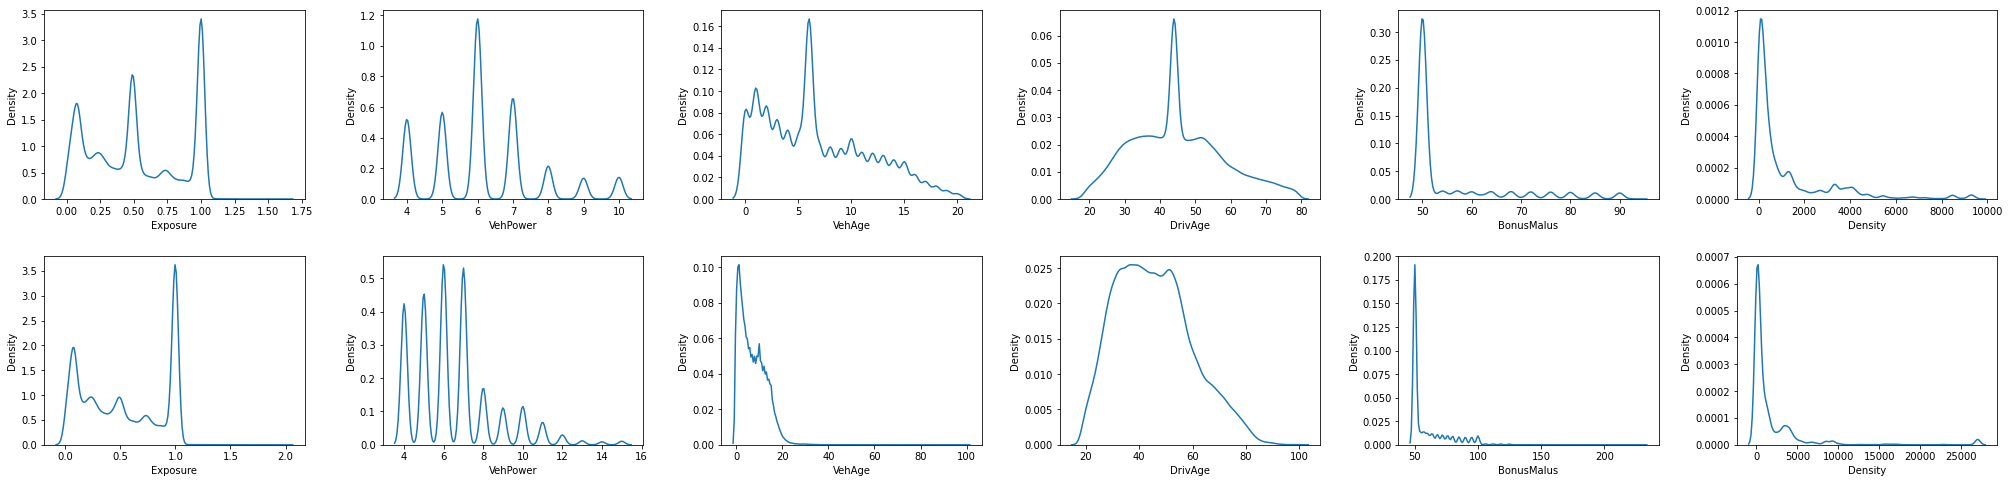

In [ ]:
fig, ax = plt.subplots(2,6,figsize=(35,8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i,column in enumerate(numeric):
  sns.kdeplot(train.loc[:,column], ax = ax[0][i])
  sns.kdeplot(test.loc[:,column], ax = ax[1][i])

По каждой из категориальных переменных можно видеть одинаковое распределение по классам, то есть ни одна из категориальных переменных сильно не коррелирует с целевой переменной

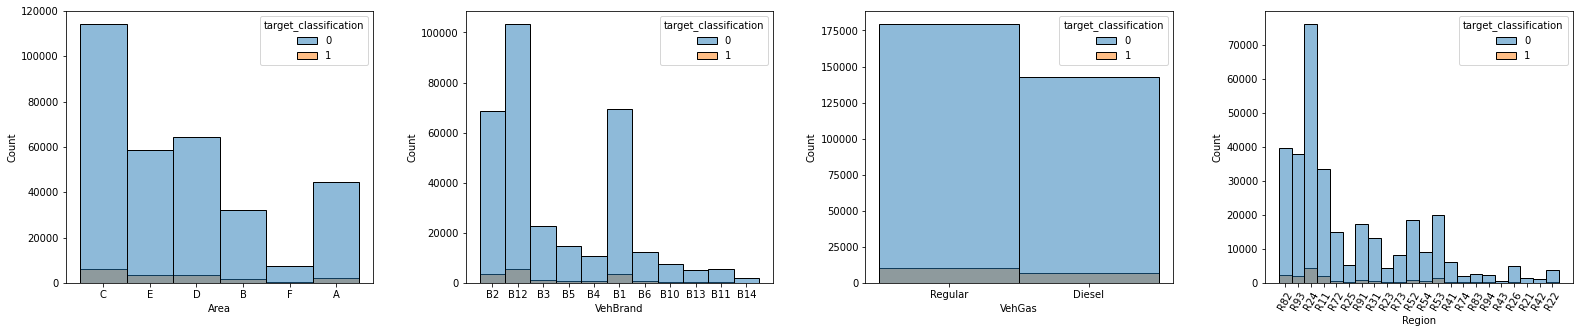

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(27,5))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i in range(4):
  sns.histplot(x=train[categorical].iloc[:,i], hue='target_classification', data=train, ax = ax[i])
  ax[3].set_xticklabels(train['Region'].unique(),rotation=60)

Видно, что значительной корреляции признаков между собой и с целевой переменной нет, поэтому на этом этапе ни один из признаков удалить нельзя.

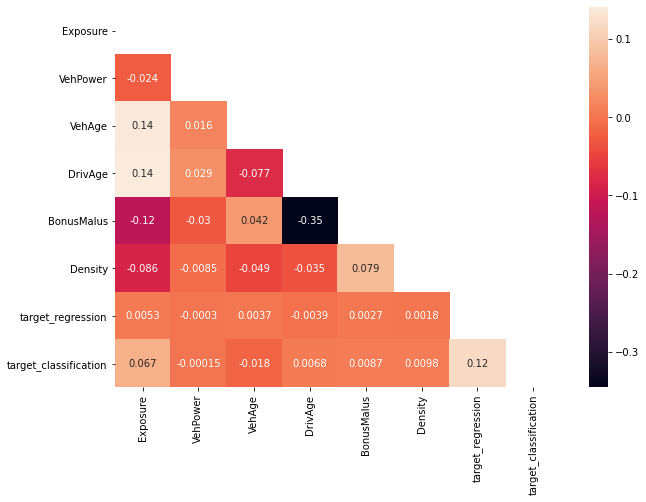

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(train.corr(),annot = True,mask=np.triu(train.corr()),)

Посомтрим на рапсределение целевой переменной регрессии.  Нулевых значений - подавляющее боольшинство.

Чем больше значение, тем меньшее количество ответов в его окрестности, уменьшение происходит примерно с одной скоростью.

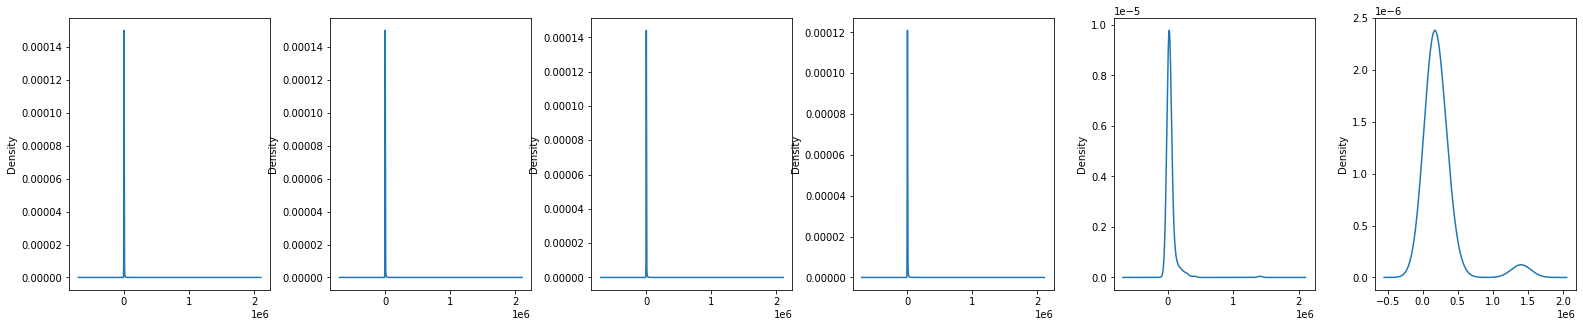

In [ ]:
fig, ax = plt.subplots(1,6,figsize=(27,5))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i,j in enumerate([min(y_regression),0,100,1000,10000,100000]):

  sub_y = y_regression[y_regression>j]
  sub_y.plot.kde(ax=ax[i],)

## Исследование признаков: генерация и отбор

Здесь проверяется гипотеза, существует ли какая-либо зависимость пар признаков от целевой переменной классификации. Апсемплинг делается для того, чтобы доля 1-го класса на графике была заметной. График строится таким образом, что при формировании групп объектов, которые преимущественно какого-то класса, происходит их графическое разделение, как на картинке здесь: https://seaborn.pydata.org/_images/histplot_41_0.png

Так как этого разделения не произошло, в документации это объясняется тем, что объекты по сгруппированному  признаку слишком смешаны, из чего следует вывод, что преобладание объектов с комбинацией каких-либо двух признаков в каком-то конкретном классе не наблюдается

In [ ]:
uped = train[train['target_classification']==1]
for i in range(35):  
  length = len(train[train['target_classification']==1])
  rand = np.random.choice(length,size = int(length/2))
  uped = pd.concat([train[train['target_classification']==1].reset_index().iloc[rand,:],uped])
upsampled = pd.concat([uped, train])

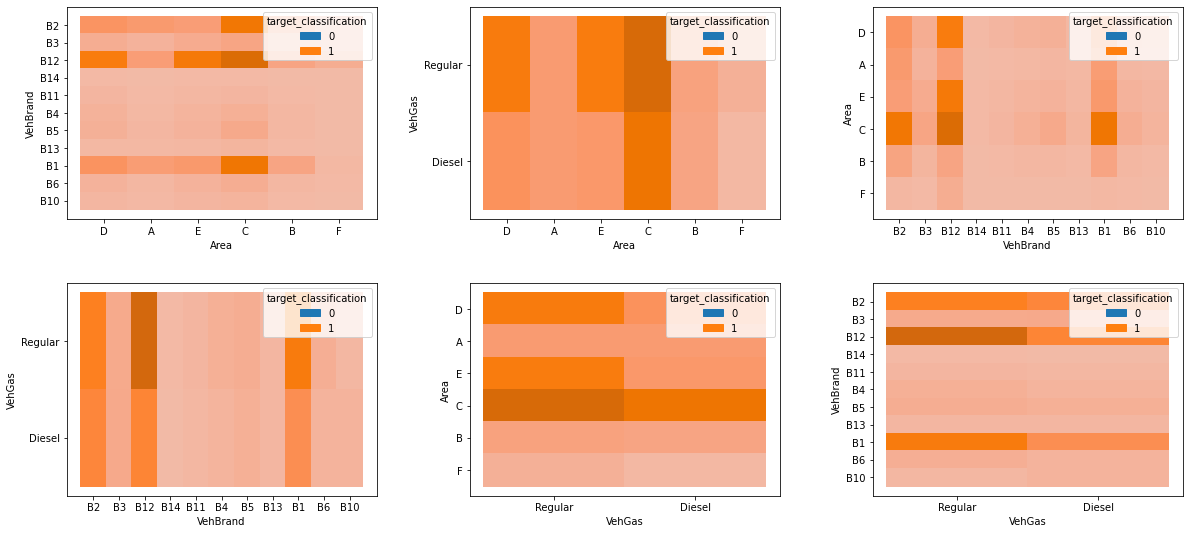

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,9))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
k = 0
for i in range(3):
  for j in range(3):
    if i == j:
      continue
    sns.histplot(x=upsampled[categorical].iloc[:,i],y=upsampled[categorical].iloc[:,j], data=upsampled, ax=ax[k//3][k%3], hue = 'target_classification')
    k+=1

Распределение в апсемплированных данных каждого признака по целевой переменной тоже схоже

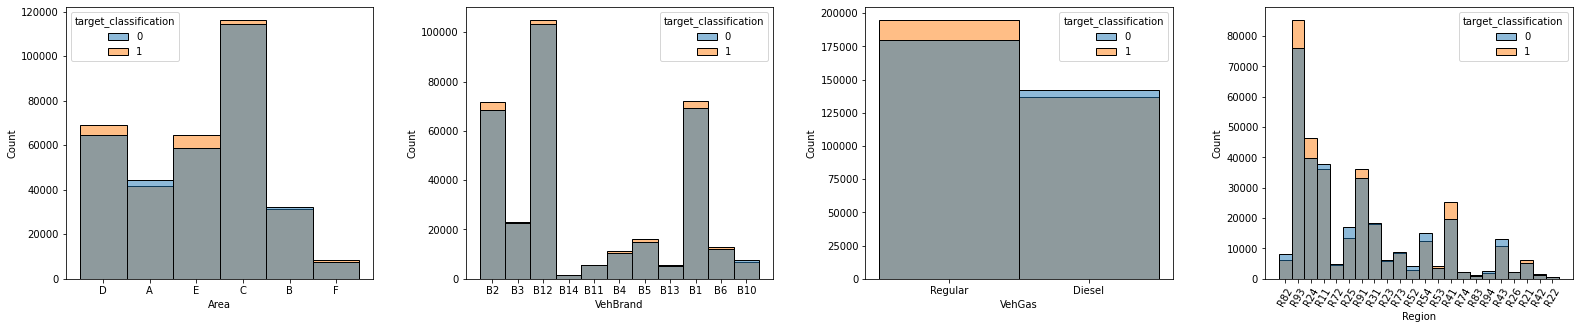

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(27,5))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i in range(4):
  sns.histplot(x=upsampled[categorical].iloc[:,i], hue='target_classification', data=upsampled, ax = ax[i])
  ax[3].set_xticklabels(train['Region'].unique(),rotation=60)

Так как у признака Exposure слишком маленькая дисперсия, его распределение близко к константному, значит он почти не влияет на трагет, поэтому его можно удалить. Однако прлогарифмировав признак можно получить дисперсию, сравнимую с дисперсией других признаков 

In [ ]:
print(np.var(train[numeric]+0.00001), np.var(np.log(train[numeric]+0.00001)),sep = '\n\n')

Exposure      1.193889e-01
VehPower      2.222721e+00
VehAge        2.440184e+01
DrivAge       1.645253e+02
BonusMalus    1.128391e+02
Density       3.402557e+06
dtype: float64

Exposure       1.231639
VehPower       0.057660
VehAge        13.010836
DrivAge        0.087421
BonusMalus     0.027644
Density        3.054709
dtype: float64


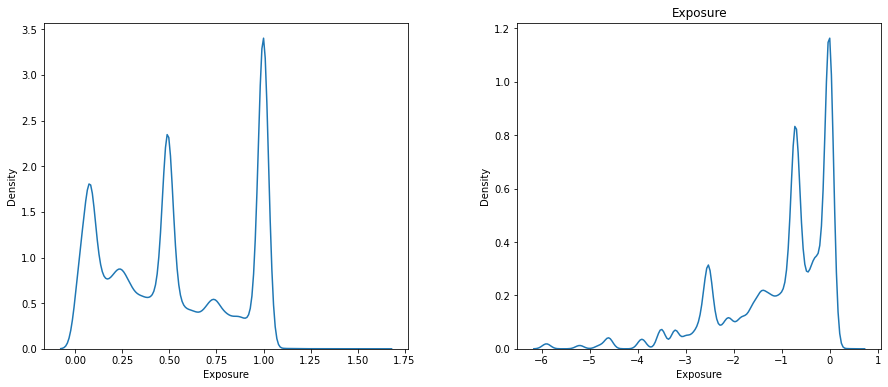

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i,x in enumerate([train.Exposure,np.log(train.Exposure)]):  
  sns.kdeplot(x,ax=ax[i])
ax[1] = plt.title('log(Exposure)')
ax[0] = plt.title('Exposure')

В данных есть признаки VehAge и DrivAge, которые показывают возраст водителя и автомобиля. Есть смысл возрастные переменные перекодировать в промежутки (20-30; 30-40..), однако это будет сделано после разделения выборки на тренировочную и тестовую 

Корреляции таргета регрессии и квадратов признаков нет

In [ ]:
X_2 = X[numeric]**2
X_2['y'] = y_regression

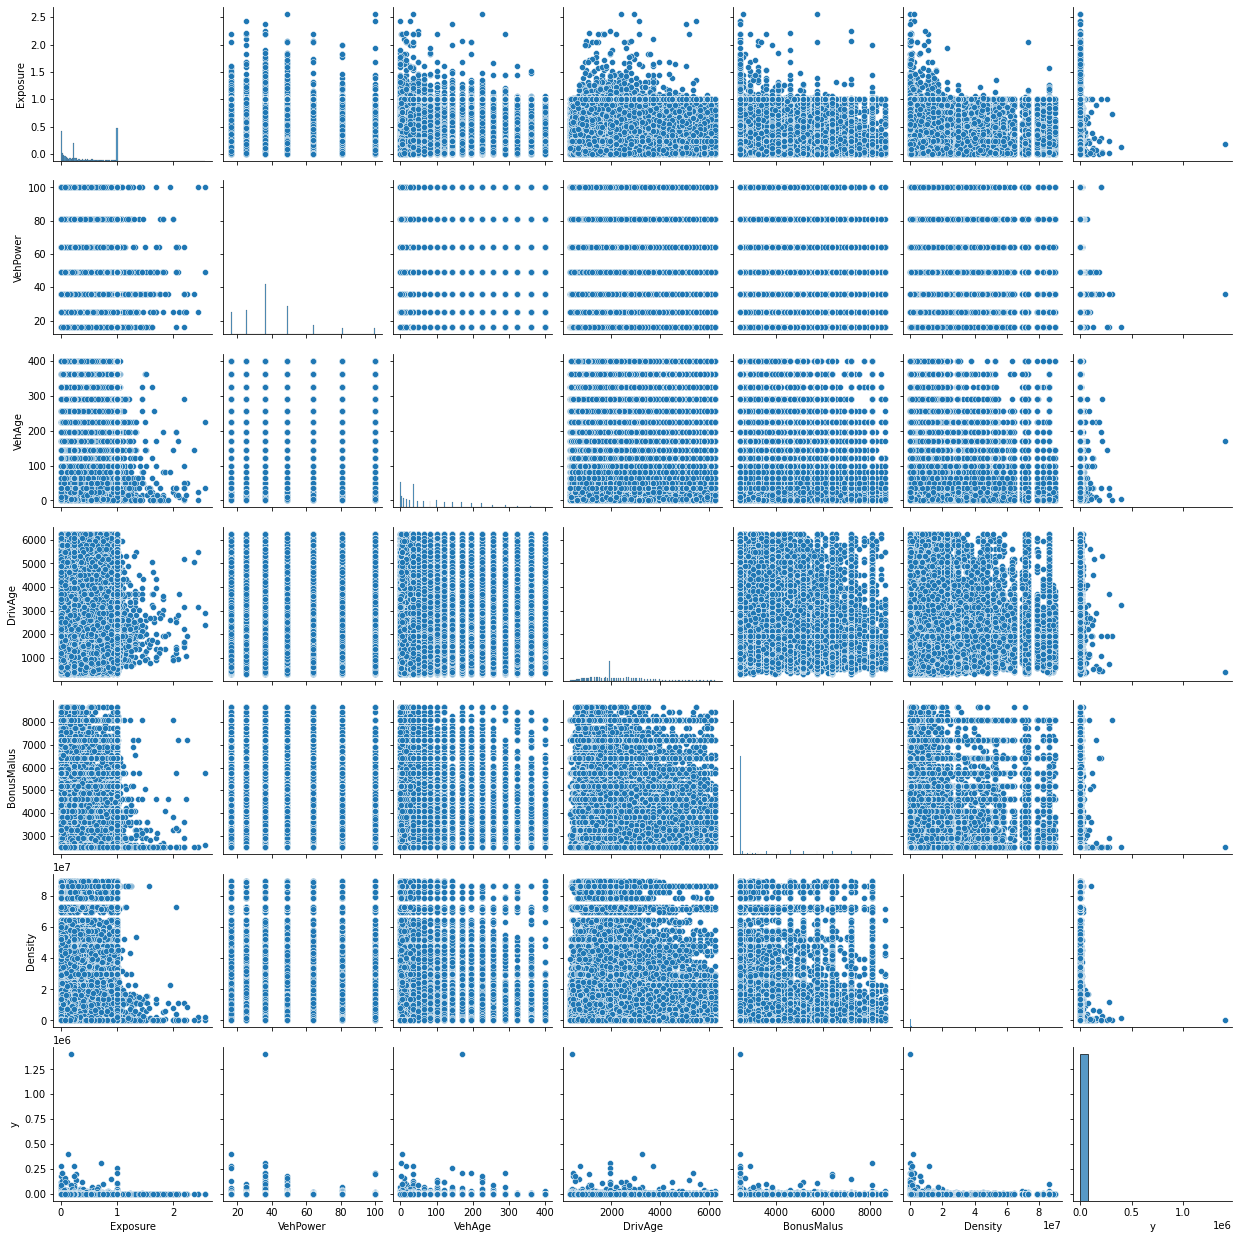

In [ ]:
sns.pairplot(X_2)

# Преобразование данных

Класс для обработки выбросов, чтобы была возможность вставить его в pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, LinearSVR
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y_classification, test_size = 0.2, random_state=42)

## Pipeline для обработанных данных

In [ ]:
num = ['VehPower', 'BonusMalus', 'Density', 'VehAge', 'DrivAge']

log_scale = Pipeline(steps=[
    ('log',FunctionTransformer(func=np.log)),
    ('scaler',StandardScaler())])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore',sparse = False), categorical),
        ("log_scale", log_scale,['Exposure']), 
        ("kbin", KBinsDiscretizer(encode='onehot',n_bins = 9, strategy = 'kmeans'),['VehAge', 'DrivAge']),
        ('num', numeric_transformer, num),
        ], remainder='passthrough')


In [ ]:
preprocessor.fit(X_train)

In [ ]:
X_train = preprocessor.transform(X_train)

In [ ]:
ohe_labels = preprocessor.transformers_[0][1].get_feature_names().tolist()
kbin_labels = [ str(i) + '_' + str(j) for i in ['VehAge', 'DrivAge'] for j in range(9)]
labels = ohe_labels+ ['Exposure'] + kbin_labels  + num

In [ ]:
X_train = pd.DataFrame(X_train, columns=labels)

# Классификация

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 55kB/s 


In [ ]:
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

## Обучающая выборка без апсемплинга

### CatBoost

In [ ]:
model = CatBoostClassifier(iterations=300,
                           depth=7,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           verbose=100, )

In [ ]:
model.fit(X_train, y_train)

0:	learn: 0.6799220	total: 189ms	remaining: 56.6s
100:	learn: 0.2319158	total: 13.7s	remaining: 27s
200:	learn: 0.1961854	total: 26.1s	remaining: 12.9s
299:	learn: 0.1907616	total: 36.6s	remaining: 0us


In [ ]:
predictions = model.predict_proba(preprocessor.transform(X_test))

На несбалансированной тренировочной выборке CatBoost всем объектам присвоил метку наиболее представленного класса

In [ ]:
np.unique(predictions, return_counts=True)

(array([0.02215063, 0.02216084, 0.02242547, ..., 0.97757453, 0.97783916,
        0.97784937]), array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([64325,  3477]))

In [ ]:
roc_auc_score(y_test,predictions.T[1])

0.6618890267854238

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
pred = rf.predict(preprocessor.transform(X_test))
predictions = rf.predict_proba(preprocessor.transform(X_test))

In [ ]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([67716,    86]))

In [ ]:
roc_auc_score(y_test,predictions.T[1])

0.6352901935890742

Добавление балансировки классов не помогло улучшить скор

In [ ]:
rf_balanced = RandomForestClassifier(class_weight='balanced')
rf_balanced.fit(X_train,y_train)
pred = rf_balanced.predict(preprocessor.transform(X_test))
predictions = rf_balanced.predict_proba(preprocessor.transform(X_test))

In [ ]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([67708,    94]))

In [ ]:
roc_auc_score(y_test,predictions.T[1])

0.6379572854584583

## Обучающая выборка с апсемплингом недопредставленного класса

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train, y_classification, test_size = 0.2, random_state=42,stratify = train.target_classification)

uped = train[train['target_classification']==1]
for i in range(38):  
  length = len(X_train[X_train['target_classification']==1])
  rand = np.random.choice(length,size = int(length/2))
  uped = pd.concat([X_train[X_train['target_classification']==1].reset_index().iloc[rand,:],uped])
upsampled = pd.concat([uped, X_train])

y_train= upsampled.target_classification
y_regression_upsampled = upsampled.target_regression
X_train = upsampled.iloc[:,[1,2,3,4,5,6,7,8,9,10]]

y_train.value_counts()

1    289510
0    257580
Name: target_classification, dtype: int64

In [ ]:
y_test.value_counts()

0    64396
1     3406
Name: target_classification, dtype: int64

In [ ]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)

ohe_labels = preprocessor.transformers_[0][1].get_feature_names().tolist()
kbin_labels = [ str(i) + '_' + str(j) for i in ['VehAge', 'DrivAge'] for j in range(9)]
labels = ohe_labels+ ['Exposure'] + kbin_labels  + num

X_train = pd.DataFrame(X_train, columns=labels)

### CatBoost

In [ ]:
model = CatBoostClassifier(iterations=300,
                           depth=7,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           verbose=100, )

In [ ]:
model.fit(X_train, y_train)

0:	learn: 0.6923675	total: 248ms	remaining: 1m 14s
100:	learn: 0.6567557	total: 20.1s	remaining: 39.6s
200:	learn: 0.6467995	total: 39.5s	remaining: 19.5s
299:	learn: 0.6410850	total: 59.6s	remaining: 0us


In [ ]:
pred = model.predict(preprocessor.transform(X_test.iloc[:,:-2]))
predictions = model.predict_proba(preprocessor.transform(X_test.iloc[:,:-2]))

На апсемплированной выборке CatBoost 50/50 предсказал ответы для тестовой выборки

In [ ]:
np.unique(pred, return_counts=True)

(array([0]), array([67802]))

In [ ]:
roc_auc_score(y_test,predictions.T[1])

0.6664304312639531

### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

In [ ]:
pred = rf.predict(preprocessor.transform(X_test.iloc[:,:-2]))
predictions = rf.predict_proba(preprocessor.transform(X_test.iloc[:,:-2]))

In [ ]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([64099,  3703]))

Да, это странно, что RandomForestClassifier работает хуже CatBoost, но если ошибка и есть, то я ее не обнаружила. Данные использовались одинаковые

In [ ]:
roc_auc_score(y_test,predictions.T[1])

0.9976790336160246

In [ ]:
from sklearn.model_selection import cross_validate
cv = cross_validate(rf,X_train,y_train)

In [ ]:
cv['test_score'].mean()

0.9901716353799191

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

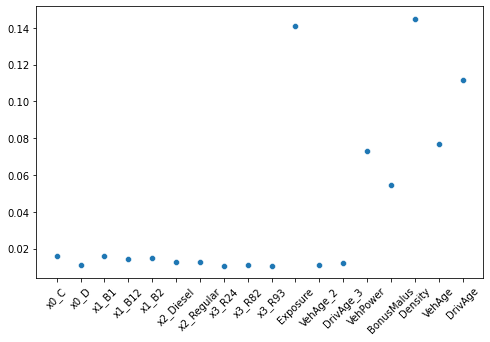

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(y = rf.feature_importances_[rf.feature_importances_>0.01], x=X_train.columns[rf.feature_importances_>0.01])
plt.xticks(rotation=45)

In [ ]:
pd.DataFrame(sorted(rf.feature_importances_)[-6:], index = X_train.columns[np.argsort(rf.feature_importances_)][-6:], columns = ['feature importance'])[::-1]

,feature importance
Density,0.144957
Exposure,0.141025
DrivAge,0.111746
VehAge,0.076677
VehPower,0.073245
BonusMalus,0.054362


In [ ]:
params = {'n_estimators': np.arange(30,150,40),
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf':[1,3,5]}

grid = GridSearchCV(RandomForestClassifier(random_state=42, oob_score = True), param_grid = params, cv = 5, verbose = 100, )

In [ ]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START criterion=gini, min_samples_leaf=1, n_estimators=30........
[CV 1/5; 1/18] END criterion=gini, min_samples_leaf=1, n_estimators=30;, score=0.996 total time=  32.7s
[CV 2/5; 1/18] START criterion=gini, min_samples_leaf=1, n_estimators=30........
[CV 2/5; 1/18] END criterion=gini, min_samples_leaf=1, n_estimators=30;, score=0.996 total time=  32.5s
[CV 3/5; 1/18] START criterion=gini, min_samples_leaf=1, n_estimators=30........
[CV 3/5; 1/18] END criterion=gini, min_samples_leaf=1, n_estimators=30;, score=0.996 total time=  32.0s
[CV 4/5; 1/18] START criterion=gini, min_samples_leaf=1, n_estimators=30........
[CV 4/5; 1/18] END criterion=gini, min_samples_leaf=1, n_estimators=30;, score=0.996 total time=  32.1s
[CV 5/5; 1/18] START criterion=gini, min_samples_leaf=1, n_estimators=30........
[CV 5/5; 1/18] END criterion=gini, min_samples_leaf=1, n_estimators=30;, score=0.966 total time=  31.1s
[CV 1/5; 2/18]

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': array([ 30,  70, 110])},
             verbose=100)

In [ ]:
print('лучший скор: ', grid.best_score_, 'лучшие параметры: ', grid.best_params_)

лучший скор:  0.9901917417609534 лучшие параметры:  {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 110}


 # Регрессия

Так как линейной (и квадратичной) зависимости с признаками нет, имеет смысл использовать только регрессоры, находящие нелинейные зависимости, среди которых SVR(), KNeighborsRegressor(), DecisionTreeRegression(), Ridge, SGDRegressor, Lasso

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y_regression, test_size = 0.2, random_state=42)

In [ ]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
ohe_labels = preprocessor.transformers_[0][1].get_feature_names().tolist()
kbin_labels = [ str(i) + '_' + str(j) for i in ['VehAge', 'DrivAge'] for j in range(9)]
labels = ohe_labels+ ['Exposure'] + kbin_labels  + num
X_train = pd.DataFrame(X_train, columns=labels)

In [ ]:
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict

Бейзлайн - среднее значение

In [ ]:
[y_test.mean()]*len(y_test)

In [ ]:
mean_squared_error(y_test,np.array([y_test.mean()]*len(y_test)), squared=False), r2_score(y_test,np.array([y_test.mean()]*len(y_test)))

(1063.94849245238, -2.220446049250313e-16)

Тренирвоочная выборка разделена пополам. Одна половина нужна для обучения базовых моделей и получения предсказаний для второй части, которые будут использоваться для обучения мета-модели. Конечный результат будет проверен на тесте

In [ ]:
x_train,x_for_meta,y_train_,y_for_meta = train_test_split(X_train, y_train, test_size = 0.5, random_state=42)

SGDRegressor

In [ ]:
linear = SGDRegressor(penalty = 'elasticnet', alpha = 1,early_stopping=True)
linear.fit(X_train,y_train)
predictions = linear.predict(preprocessor.transform(X_test))

In [ ]:
mean_squared_error(y_test,predictions, squared=False), r2_score(y_test,predictions)

(1064.1162247161233, -0.00031532632733810573)

Предсказания для стекинга

In [ ]:
linear.fit(x_train,y_train_)
predictions_sgd_train = linear.predict(x_for_meta)
predictions_sgd_test = linear.predict(preprocessor.transform(X_test))

PoissonRegressor

In [ ]:
from sklearn.linear_model import PoissonRegressor

In [ ]:
poisson = PoissonRegressor(alpha=0.01, verbose = True)
poisson.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor(alpha=0.01, verbose=True)

In [ ]:
predictions = poisson.predict(preprocessor.transform(X_test))
mean_squared_error(y_test,predictions, squared=False), r2_score(y_test,predictions)

(1065.1630777926266, -0.0022844688887817544)

Стекинг

In [ ]:
poisson.fit(x_train,y_train_)
predictions_poisson_train = poisson.predict(x_for_meta)
predictions_poisson_test = poisson.predict(preprocessor.transform(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(max_depth=4, max_features=1/3,oob_score=True,verbose = True, n_estimators=300)
regressor.fit(X_train,y_train)
predictions = regressor.predict(preprocessor.transform(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished


In [ ]:
mean_squared_error(y_test,predictions, squared=False), r2_score(y_test,predictions)

(1073.657773690309, -0.018334690693367683)

Стекинг

In [ ]:
regressor.fit(x_train,y_train_)
predictions_rf_train = regressor.predict(x_for_meta)
predictions_rf_test = regressor.predict(preprocessor.transform(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   46.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.0s finished


LinearSVR

In [ ]:
from sklearn.svm import LinearSVR

In [ ]:
svr = LinearSVR()
svr.fit(X_train, y_train)
predictions_svr = svr.predict(preprocessor.transform(X_test))

mean_squared_error(y_test,predictions_svr, squared=False), r2_score(y_test,predictions_svr)

(1066.2199975188269, -0.004274511195958786)

Стекинг

In [ ]:
svr.fit(x_train,y_train_)
predictions_svr_train = svr.predict(x_for_meta)
predictions_svr_test = svr.predict(preprocessor.transform(X_test))

In [ ]:
params = {'classifier__kernel': ['linear', 'poly', 'rbf','sigmoid'],
          'classifier__C': [1,.1,0.01,0.001],
          'classifier__epsilon': [.1,0.01,0.001]}
# params = {'kernel_label' = ['RBF', 'Linear', 'Polynomial'],
#           'svrs' = [svr_rbf, svr_lin, svr_poly]
#           'epsilon'=[.1,0.01,0.001]
# 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
grid = GridSearchCV(clf, param_grid = params, cv = 5, verbose = 100, )


In [ ]:
!pip install keras

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense, ReLU
from keras.activations import relu
from keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Dense(64, activation='sigmoid'))
model.add(ReLU())
model.add(Dense(50, activation='sigmoid'))
model.add(ReLU())
model.add(Dense(25, activation='softmax'))

model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[keras.metrics.RootMeanSquaredError()], run_eagerly=True)

In [ ]:
new_X = np.array([predictions_sgd_train,predictions_poisson_train,predictions_rf_train,predictions_svr_train])

In [ ]:
new_X=new_X.T

In [ ]:
history = model.fit(new_X, 
                    y_for_meta, 
                    epochs=20, 
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/20
3814/3814 - 84s - loss: 4125668.2500 - root_mean_squared_error: 2031.1741 - val_loss: 974875.6875 - val_root_mean_squared_error: 987.3579
Epoch 2/20
3814/3814 - 95s - loss: 4125464.5000 - root_mean_squared_error: 2031.1239 - val_loss: 974725.5625 - val_root_mean_squared_error: 987.2819
Epoch 3/20
3814/3814 - 84s - loss: 4125314.5000 - root_mean_squared_error: 2031.0870 - val_loss: 974585.7500 - val_root_mean_squared_error: 987.2111
Epoch 4/20
3814/3814 - 94s - loss: 4125123.7500 - root_mean_squared_error: 2031.0400 - val_loss: 974459.3125 - val_root_mean_squared_error: 987.1470
Epoch 5/20
3814/3814 - 85s - loss: 4124940.0000 - root_mean_squared_error: 2030.9949 - val_loss: 974350.3125 - val_root_mean_squared_error: 987.0919
Epoch 6/20
3814/3814 - 85s - loss: 4124788.2500 - root_mean_squared_error: 2030.9575 - val_loss: 974221.0000 - val_root_mean_squared_error: 987.0264
Epoch 7/20
3814/3814 - 84s - loss: 4124749.2500 - root_mean_squared_error: 2030.9479 - val_loss: 974110.93

In [ ]:
new_test =np.array([predictions_sgd_test,predictions_poisson_test,predictions_rf_test,predictions_svr_test])

In [ ]:
meta_preds = model.predict(new_test.T)

RMSE и R2 для стекинга с нейросейтью в качестве метамодели

In [ ]:
mean_squared_error(y_test,meta_preds, squared=False), r2_score(y_test,meta_preds)

(1064.428423006812, -0.0009023722528442857)

RMSE и R2 для стекинга с Lasso в качестве метамодели 

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()

In [ ]:
lasso.fit(new_X, y_for_meta)

Lasso()

In [ ]:
ensemble_preds = lasso.predict(new_test.T)

In [ ]:
mean_squared_error(y_test,ensemble_preds, squared=False), r2_score(y_test,ensemble_preds)

(1063.8045078978857, 0.0002706424470230173)

В результате не получилось уменьшить RMSE меньше, чем в бейзлайн-модели, где предсказывается среднее значение

# 1.2 Кластеризация

1. кластеризовать заданный набор данных (*task2_train_v5.csv*). Предложить метрику и проверить качество.
2. получить предсказания (номер кластера), сохранить в файл с расширением *csv* и приложить к решению.

In [ ]:
train = pd.read_csv('/content/task2_v5.csv', sep=';')

In [ ]:
train.head()

,stat_1,stat_2,stat_3,stat_4
0,-1.644344,-23.710424,-10.591175,-19.352089
1,7.463911,-9.787539,-6.299809,11.091527
2,11.536239,-12.075189,-14.095199,10.378562
3,-4.759128,-9.926430,-22.051245,-22.581364
4,9.161899,-4.731807,-11.386896,13.145629


В данных нет выбросов и пропусков

In [ ]:
train.isna().sum()

stat_1    0
stat_2    0
stat_3    0
stat_4    0
dtype: int64

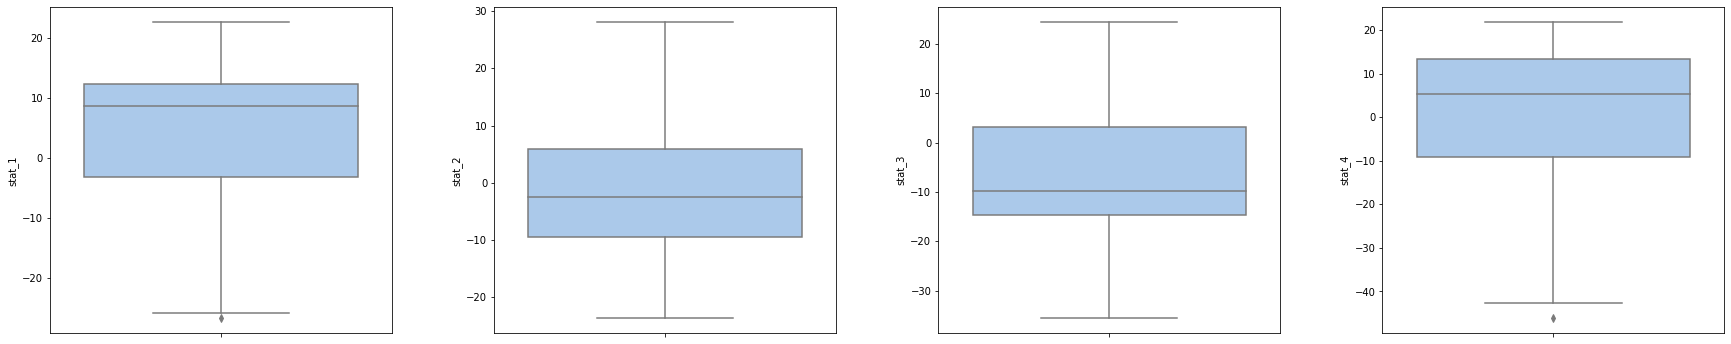

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,4, figsize=(30,6))
plt.subplots_adjust(wspace=0.3, hspace=0)
for i,column in enumerate(train.columns):
  sns.boxplot(y = train[column], orient='v',ax=ax[i],palette="pastel", data = train)

Так как данные перед применение PCA в sklearn центируются, но не масштабируются, необходимо применить StandardScaler перед PCA

In [ ]:
scaler = StandardScaler()
train = scaler.fit_transform(train)

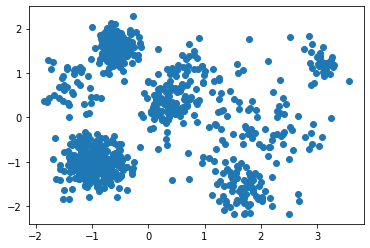

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train)


plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.show()

TSNE - метод визуализации данных больших размерностей. Он основан на вычислении близости точек при гауссовском распределении плотности с центром в одной из точек. Он гораздо лучше визуализирует разницу между различными классами, более явно отделяет один от другого минимизируя расстояние Кульбака — Лейблера. Тем не менее использовать его в качестве метода понижения размерности не рекомендуется, так как такие методы как PCA более стабильны и с большей эффективностью подавляют шум.

На рисунке видно, что достаточно явно отделились 7 или 8 кластеров, если делить нижний на 2.

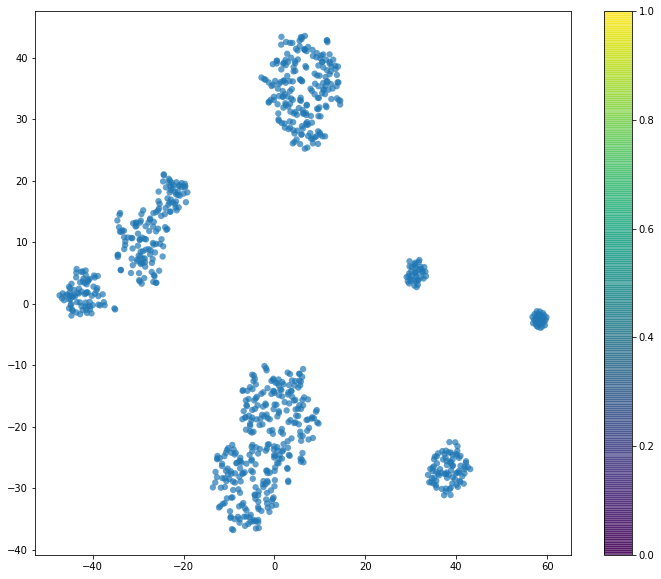

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(train)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

Будем использовать 2 метрики: calinski_harabasz_score, которая представляет собой отношение суммы дисперсии между кластерами и дисперсии внутри кластера для каждого из кластеров и Silhouette Coefficient, которая высчитывается для каждого объекта и сравнивает расстояние от объекта до дргуих объектов в этом кластере с расстояниями до ближайшего кластера

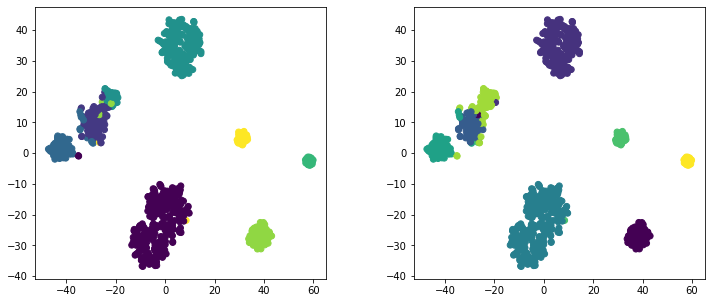

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.3, hspace=0)
k_means_7 = KMeans(n_clusters = 7)
k_means_8 = KMeans(n_clusters = 8)
k_means_7 = k_means_7.fit(train)
k_means_8 = k_means_8.fit(train)

ax[0].scatter(X_tsne[:,0], X_tsne[:,1], c=k_means_7.labels_)
ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=k_means_8.labels_)

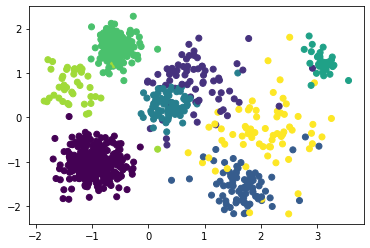

In [ ]:
k_means = KMeans(n_clusters = 8)
k_means = k_means.fit(train)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = k_means.labels_)
plt.show()

K-Means

In [ ]:
harabasz,  silhouette = np.array([]),  np.array([])

for num in [6,7,8,9, 10]:
  k_means = KMeans(n_clusters = num)
  k_means = k_means.fit(train)
  harabasz = np.append(harabasz, metrics.calinski_harabasz_score(train, k_means.labels_))
  silhouette = np.append(silhouette, metrics.silhouette_score(train, k_means.labels_, sample_size=1000))
metrics_k_means = pd.DataFrame(np.array([harabasz, silhouette]).T, columns= ['harabasz', 'silhouette'], index = [6,7,8,9,10])

metrics_k_means

,harabasz,silhouette
6,761.429942,0.598196
7,896.040037,0.613936
8,936.792970,0.614948
9,906.728768,0.609049
10,860.066237,0.441486


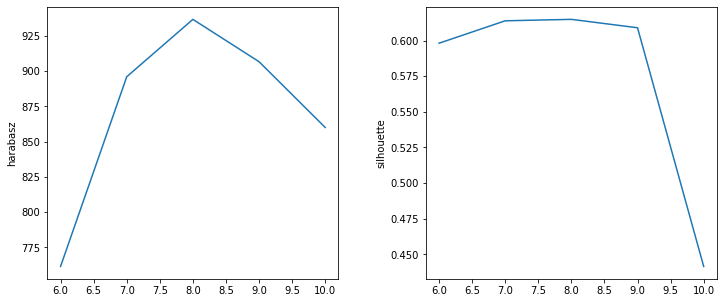

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
plt.subplots_adjust(wspace=0.3, hspace=0)

sns.lineplot(data = metrics_k_means.iloc[:,0], ax=ax[0])
sns.lineplot(data = metrics_k_means.iloc[:,1], ax=ax[1])

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
metrics_k_means.style.apply(highlight_max)

,harabasz,silhouette
6,761.429942,0.598196
7,896.040037,0.613936
8,936.792970,0.614948
9,906.728768,0.609049
10,860.066237,0.441486


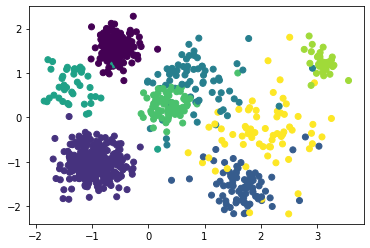

In [ ]:
k_means = KMeans(n_clusters = 8)
k_means = k_means.fit(train)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = k_means.labels_)
plt.show()

DBSCAN

У DBSCAN есть 2 параметра, которые сильно влияют на количество кластеров - eps и min_samples. eps отвечает за расстояние, на котором должны находиться объекты, чтобы считаться соседними, min_samples - количество точек, необходимых быть в окрестности eps какого-либо конкретного объекта, чтобы считать его основным.

In [ ]:
from sklearn.cluster import DBSCAN
harabasz, silhouette = np.array([]), np.array([])

for eps in [0.2,0.3,0.4,0.5,1,1.5]:
  for min_samples in [1,2,3,4,5,6,7]:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db = db.fit(train)
    harabasz = np.append(harabasz, metrics.calinski_harabasz_score(train,db.labels_))
    silhouette = np.append(silhouette, metrics.silhouette_score(train, db.labels_, sample_size=1000))

harabasz_db = pd.DataFrame(harabasz.reshape(-1,7), columns = [1,2,3,4,5,6,7], index = [0.2,0.3,0.4,0.5,1,1.5])
silhouette_db = pd.DataFrame(silhouette.reshape(-1,7), columns = [1,2,3,4,5,6,7], index = [0.2,0.3,0.4,0.5,1,1.5])

In [ ]:
harabasz_db.style.highlight_max(np.invert(harabasz_db.ne(harabasz_db.max().max()).all()))

,1,2,3,4,5,6,7
0.2,71.211623,13.332444,26.957331,32.675000,44.573156,32.821679,28.819477
0.3,71.777442,62.347907,137.023661,141.694950,204.116139,187.165490,200.005659
0.4,102.712364,158.367713,307.585477,346.033371,279.271792,311.298895,312.856436
0.5,139.678883,271.037707,435.873367,601.544082,543.151190,636.884894,605.019245
1.0,24.165657,50.610096,62.905563,85.633525,87.176984,87.176984,191.257528
1.5,67.257071,67.257071,67.257071,67.257071,67.257071,67.257071,67.257071


In [ ]:
silhouette_db.style.highlight_max(np.invert(silhouette_db.ne(silhouette_db.max().max()).all()))

,1,2,3,4,5,6,7
0.2,-0.069889,-0.312666,-0.278608,-0.299460,-0.166827,-0.190150,-0.145234
0.3,-0.060758,0.093350,0.177975,0.289091,0.333530,0.309770,0.300419
0.4,0.126863,0.314016,0.413784,0.465990,0.460133,0.446240,0.427385
0.5,0.306970,0.404756,0.540691,0.539840,0.521897,0.558686,0.552523
1.0,-0.021482,0.176417,0.191294,0.229888,0.230160,0.230160,0.367575
1.5,0.401223,0.401223,0.401223,0.401223,0.401223,0.401223,0.401223


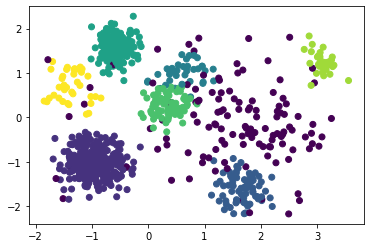

In [ ]:
db = DBSCAN(eps=0.5, min_samples=6)
db = db.fit(train)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = db.labels_)
plt.show()

hierarchy clastering

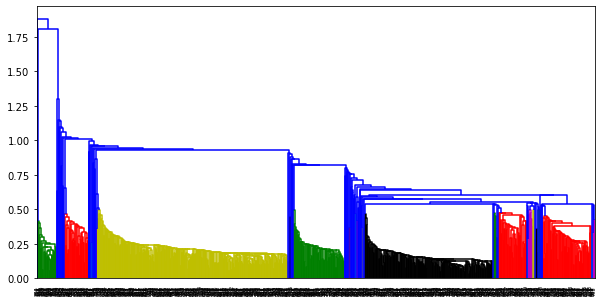

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

distance_mat = pdist(train)

Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

harabasz,  silhouette = np.array([]),  np.array([])

for num in [6,7,8,9,10]:
  cluster = AgglomerativeClustering(n_clusters=num, affinity='euclidean', linkage='ward')
  cluster.fit_predict(train)
  harabasz = np.append(harabasz, metrics.calinski_harabasz_score(train, cluster.labels_))
  silhouette = np.append(silhouette, metrics.silhouette_score(train, cluster.labels_, sample_size=1000))
metrics_agg = pd.DataFrame(np.array([harabasz, silhouette]).T, columns= ['harabasz', 'silhouette'], index = [6,7,8,9,10])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
metrics_agg.style.apply(highlight_max)

,harabasz,silhouette
6,736.792642,0.593973
7,818.367029,0.597514
8,832.952685,0.580700
9,806.686917,0.581149
10,779.703834,0.574728


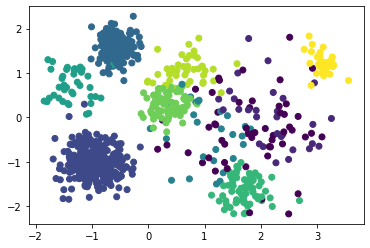

In [ ]:
db = DBSCAN(eps=0.5, min_samples=6)
db = db.fit(train)

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c = cluster.labels_)
plt.show()

Сводная таблица по результатам кластеризации разными методами. KMEANS показал лучшие резульаты по обеим метрикам с количеством кластеров, равным 8

In [ ]:
kmeans = metrics_k_means.max()
db_scan = np.array([harabasz_db.max().max(), silhouette_db.max().max()])
hierarchy = metrics_agg.max()

In [ ]:
pd.DataFrame([kmeans.values,db_scan,hierarchy.values], columns=['harabasz_score','silhouette'], index = ['kmeans', 'db_scan', 'hierarchy'])

,harabasz_score,silhouette
kmeans,936.792970,0.614948
db_scan,636.884894,0.558686
hierarchy,832.952685,0.597514


# Предсказания

## Кластеризация

In [ ]:
submit = pd.DataFrame({'preds': k_means_8.labels_})
submit.to_csv('/content/predictions_2.csv', index=False)

## Регрессия и классификация

Полный pipeline с написанным классом удаления выбрсоов для встраивания его в pipeline

In [ ]:
class Outliers:

  def __init__(
        self): 
    self.max = 0
    self.min = 0
    self.median = 0

  def fit(self,dataset,y=None):
    data = pd.DataFrame(dataset.copy())
    description = data.describe()
    self.max = description.iloc[-2,:]+2*description.iloc[2,:]
    self.min = description.iloc[3,:]-2*description.iloc[2,:]
    self.median = train[numeric].median()

  def transform(self,dataset,y=None):  
    data = pd.DataFrame(dataset.copy())
    for i,column in enumerate(data):
      data[column][data[column]>self.max[i]] = self.median[i]
      data[column][data[column]<self.min[i]] = self.median[i]
    return data

  def fit_transform(self,dataset,y=None):
    data = pd.DataFrame(dataset.copy())
    description = data.describe()
    self.max = description.iloc[-2,:]+2*description.iloc[2,:]
    self.min = description.iloc[3,:]-2*description.iloc[2,:]
    self.median = pd.DataFrame(train).median()
    for i,column in enumerate(data):
      data[column][data[column]>self.max[i]] = self.median[i]
      data[column][data[column]<self.min[i]] = self.median[i]

    return data.values

In [ ]:
num = ['VehPower', 'BonusMalus', 'Density', 'VehAge', 'DrivAge']
num_out = ['VehPower', 'BonusMalus', 'Density', 'VehAge', 'DrivAge','Exposure']

log_scale = Pipeline(steps=[
    ('log',FunctionTransformer(func=np.log)),
    ('scaler',StandardScaler())])

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
out = Pipeline(steps=[('outliers', Outliers())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore',sparse = False), categorical),
        ('outliers', out, num),
        ("log_scale", log_scale,['Exposure']), 
        ("kbin", KBinsDiscretizer(encode='onehot',n_bins = 9, strategy = 'kmeans'),['VehAge', 'DrivAge']),
        ('num', numeric_transformer, num),
        ], remainder='passthrough')


In [ ]:
train = pd.read_csv('/content/task1_train_v5.csv', sep=';')
test = pd.read_csv('/content/task1_test_v5.csv', sep=';')
train = imputer(train,numeric,categorical)
train[numeric] = Outliers().fit_transform(train[numeric])
test[numeric] = Outliers().transform(test[numeric])

In [ ]:
test = preprocessor.transform(test.iloc[:,1:])

In [ ]:
preds = rf.predict_proba(pd.DataFrame(test)).T[1]

In [ ]:
pred_regr = regressor.predict(test)

In [ ]:
submit = pd.DataFrame({'target_classification': preds, 'target_regression': pred_regr})
submit.to_csv('/content/predictions_1.csv', index=False)